In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import utils

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import motifs
from Bio.SeqUtils import GC
from scipy.optimize import curve_fit
from scipy.stats import gamma, poisson, nbinom, binom
from scipy.signal import argrelmin
from scipy.misc import factorial
from sklearn import linear_model

In [2]:
# Open various files as DataFrames
genes_fname = '../data/HnTnSeqAnalysis/Halo/genes.GC'
genes_df = pd.read_csv(genes_fname, sep='\t')

pool1_fname = '../data/HnTnSeqAnalysis/DSJD02HTn1_R1/DSJDo2Htn1_S1_l006_R1_001.pool'
pool1_df = pd.read_csv(pool1_fname, sep='\t')

pool2_fname = '../data/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool'
pool2_df = pd.read_csv(pool2_fname, sep='\t')

genome_fname = "../data/berkeleylab-feba-7de9bcaf0960/bin/g/Halo/genome.fna"
genome_len = None
for req in SeqIO.parse(genome_fname, "fasta"):
    genome_len = len(req)
    
print('Hnea genome is %d bp' % genome_len)

Hnea genome is 2582886 bp


In [3]:
def calc_p_nonessential(genes_df, genome_len, pool_df):
    """Assigns P-values for likelihood of non-essentiality. 
    
    Args:
        genes_df: DataFrame describing the genes.
        genome_len: length of the genome
        pool_df: DataFrame describing the position of inserts.
    
    Returns:
        A pointer to a modified copy of genes_df containing essentiality info.
    """
    # add additional columns to gene dataframe to hold intermediate values
    n_genes = len(genes_df)
    
    genes_df_copy = genes_df.copy()
    genes_df_copy['pval_raw'] = np.zeros(n_genes)
    genes_df_copy['pval_corr'] = np.zeros(n_genes)
    genes_df_copy['length'] = np.zeros(n_genes)
    genes_df_copy['n_inserts'] = np.zeros(n_genes)
    
    # calculate a naive estimate of insertion rate from the length of the genome
    mask = pool_df.pos.notnull()
    insertions = pool_df[mask].pos.values
    total_inserts = len(insertions)
    rate = total_inserts/genome_len
    print('Predicted rate of insertion: %s' % rate)
    
    starts = genes_df_copy[['begin', 'end']].min(axis=1)
    ends = genes_df_copy[['begin', 'end']].max(axis=1)
    lens = ends - starts
    
    for gene in genes_df_copy.itertuples():
        idx = gene[0]
        start = starts.loc[idx]
        end = ends.loc[idx]
        gene_length = lens.loc[idx]
        
        inserts_in_gene_mask = (pool_df.pos>start) & (pool_df.pos<end)
        num_inserts = len(pool_df[inserts_in_gene_mask])

        # Calculate a P-value assuming a null model of random insertion throughout genome
        pval_raw = binom.cdf(num_inserts, gene_length, rate)
        # Bonferroni correction for the total number of comparisons = total number of genes
        pval_corr = n_genes*pval_raw

        # update the gene with the new charecteristics
        genes_df_copy.at[idx, 'pval_raw'] = pval_raw
        genes_df_copy.at[idx, 'pval_corr'] = pval_corr
        
        genes_df_copy.at[idx, 'length'] = gene_length
        genes_df_copy.at[idx, 'n_inserts'] = num_inserts
    return genes_df_copy

In [4]:
# Calculating essentiality for the first replicate sequencing of the library.
essential_df1 = calc_p_nonessential(genes_df, genome_len, pool1_df)
essential_df1.head(n=10)

Predicted rate of insertion: 0.03968854993987346


,locusId,sysName,type,scaffoldId,begin,end,strand,name,desc,GC,nTA,pval_raw,pval_corr,length,n_inserts
0,HNEAP_RS00015,HNEAP_RS00015,1,NC_013422.1,159,1559,+,NaN,chromosomal replication initiator protein DnaA,0.5353,30,4.124691e-22,9.932256e-19,1400.0,2.0
1,HNEAP_RS00020,HNEAP_RS00020,1,NC_013422.1,1623,2735,+,NaN,DNA polymerase III subunit beta,0.5346,22,3.051187e-17,7.347258e-14,1112.0,2.0
2,HNEAP_RS00025,HNEAP_RS00025,1,NC_013422.1,2815,3840,+,NaN,DNA replication and repair protein RecF,0.5536,16,9.999327e-01,2.407838e+03,1025.0,66.0
3,HNEAP_RS00030,HNEAP_RS00030,1,NC_013422.1,4029,6482,+,NaN,DNA topoisomerase (ATP-hydrolyzing) subunit B,0.5534,49,7.192812e-44,1.732029e-40,2453.0,0.0
4,HNEAP_RS00035,HNEAP_RS00035,1,NC_013422.1,6658,7233,+,NaN,LemA family protein,0.5330,16,9.999644e-01,2.407914e+03,575.0,43.0
5,HNEAP_RS00040,HNEAP_RS00040,1,NC_013422.1,7248,8171,+,NaN,hypothetical protein,0.5390,22,9.996937e-01,2.407262e+03,923.0,58.0
6,HNEAP_RS00045,HNEAP_RS00045,1,NC_013422.1,8681,9454,+,NaN,exodeoxyribonuclease III,0.5103,26,9.878855e-01,2.378828e+03,773.0,43.0
7,HNEAP_RS00050,HNEAP_RS00050,1,NC_013422.1,9655,12165,-,NaN,ABC transporter permease,0.5707,48,9.636449e-01,2.320457e+03,2510.0,117.0
8,HNEAP_RS00055,HNEAP_RS00055,1,NC_013422.1,12156,12896,-,NaN,ABC transporter,0.5789,10,9.999952e-01,2.407988e+03,740.0,55.0
9,HNEAP_RS00060,HNEAP_RS00060,1,NC_013422.1,13056,13742,+,NaN,arylesterase,0.5546,16,9.999999e-01,2.408000e+03,686.0,57.0


In [5]:
# Calculating essentiality for the first replicate sequencing of the library.
essential_df2 = calc_p_nonessential(genes_df, genome_len, pool2_df)
essential_df2.head(n=20)

Predicted rate of insertion: 0.03849531105902467


,locusId,sysName,type,scaffoldId,begin,end,strand,name,desc,GC,nTA,pval_raw,pval_corr,length,n_inserts
0,HNEAP_RS00015,HNEAP_RS00015,1,NC_013422.1,159,1559,+,NaN,chromosomal replication initiator protein DnaA,0.5353,30,2.204458e-21,5.308334e-18,1400.0,2.0
1,HNEAP_RS00020,HNEAP_RS00020,1,NC_013422.1,1623,2735,+,NaN,DNA polymerase III subunit beta,0.5346,22,1.140739e-16,2.746900e-13,1112.0,2.0
2,HNEAP_RS00025,HNEAP_RS00025,1,NC_013422.1,2815,3840,+,NaN,DNA replication and repair protein RecF,0.5536,16,9.999144e-01,2.407794e+03,1025.0,64.0
3,HNEAP_RS00030,HNEAP_RS00030,1,NC_013422.1,4029,6482,+,NaN,DNA topoisomerase (ATP-hydrolyzing) subunit B,0.5534,49,1.512865e-42,3.642978e-39,2453.0,0.0
4,HNEAP_RS00035,HNEAP_RS00035,1,NC_013422.1,6658,7233,+,NaN,LemA family protein,0.5330,16,9.997002e-01,2.407278e+03,575.0,39.0
5,HNEAP_RS00040,HNEAP_RS00040,1,NC_013422.1,7248,8171,+,NaN,hypothetical protein,0.5390,22,9.998580e-01,2.407658e+03,923.0,58.0
6,HNEAP_RS00045,HNEAP_RS00045,1,NC_013422.1,8681,9454,+,NaN,exodeoxyribonuclease III,0.5103,26,9.883955e-01,2.380056e+03,773.0,42.0
7,HNEAP_RS00050,HNEAP_RS00050,1,NC_013422.1,9655,12165,-,NaN,ABC transporter permease,0.5707,48,9.655563e-01,2.325060e+03,2510.0,114.0
8,HNEAP_RS00055,HNEAP_RS00055,1,NC_013422.1,12156,12896,-,NaN,ABC transporter,0.5789,10,9.999916e-01,2.407980e+03,740.0,53.0
9,HNEAP_RS00060,HNEAP_RS00060,1,NC_013422.1,13056,13742,+,NaN,arylesterase,0.5546,16,9.999999e-01,2.408000e+03,686.0,56.0


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


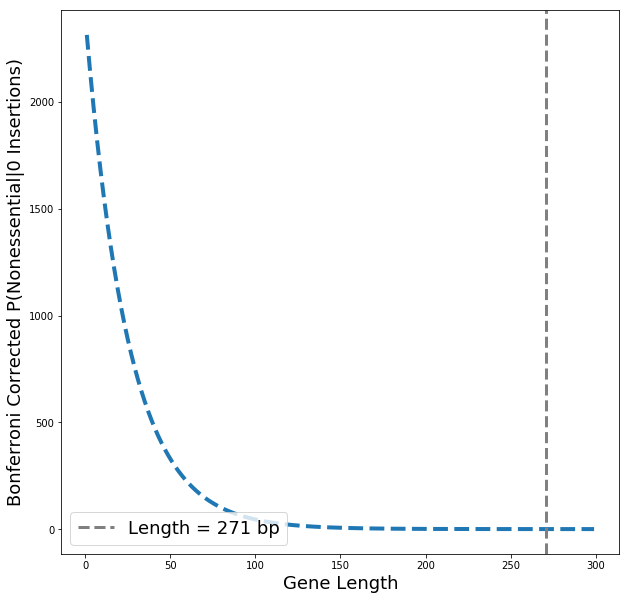

In [6]:
n_genes = len(genes_df)
approximate_rate = 0.039
gene_lens = np.arange(1, 300)
nonessential_prob = binom.cdf(0, gene_lens, approximate_rate) * n_genes
min_essential_length = np.argmin(nonessential_prob > 0.05)

figure = plt.figure(figsize=(10,10))
plt.plot(gene_lens, nonessential_prob, ls='--', lw=4)
plt.axvline(min_essential_length, ls='--', c='grey', lw=3,
            label='Length = %d bp' % min_essential_length)
plt.legend(loc=3, fontsize=18)
plt.xlabel('Gene Length', fontsize=18)
plt.ylabel('Bonferroni Corrected P(Nonessential|0 Insertions)', fontsize=18)
plt.show()


In [7]:
# Genes are called essential if the corrected P value in both replicates is less than 0.05.
# Note - it is possible to correct for various factors that affect insertion
# probability, e.g. GC content. However this makes almost not difference in our case.
p_corr_threshold = 0.05
rep1_essential = essential_df1.pval_corr < p_corr_threshold
rep2_essential = essential_df2.pval_corr < p_corr_threshold
essential = rep1_essential & rep2_essential

# Genes are ambiguous if they are too short to call essential with 0 insertions (see calculation above)
# and also have no insertions in either replicate
too_short = essential_df1.length < min_essential_length
ambiguous_rep1 = (too_short) & (essential_df1.n_inserts == 0)
ambiguous_rep2 = (too_short) & (essential_df2.n_inserts == 0)
ambiguous = ambiguous_rep1 & ambiguous_rep2

# Remaining genes are called non-essential
non_essential = np.logical_not(essential) & np.logical_not(ambiguous)


# make a merged dataframe for output
merge_on = genes_df.columns.tolist()
merged_df = essential_df1.merge(essential_df2, how='outer', on=merge_on, suffixes=('_rep1', '_rep2'))

merged_df['essentiality'] = ['essential']*n_genes
merged_df.at[ambiguous, 'essentiality'] = 'ambiguous'
merged_df.at[non_essential, 'essentiality'] = 'nonessential'

# Save the essentiality calls
merged_df.to_csv('../data/essentiality_calls.csv')

merged_df.head(n=10)

,locusId,sysName,type,scaffoldId,begin,end,strand,name,desc,GC,nTA,pval_raw_rep1,pval_corr_rep1,length_rep1,n_inserts_rep1,pval_raw_rep2,pval_corr_rep2,length_rep2,n_inserts_rep2,essentiality
0,HNEAP_RS00015,HNEAP_RS00015,1,NC_013422.1,159,1559,+,NaN,chromosomal replication initiator protein DnaA,0.5353,30,4.124691e-22,9.932256e-19,1400.0,2.0,2.204458e-21,5.308334e-18,1400.0,2.0,essential
1,HNEAP_RS00020,HNEAP_RS00020,1,NC_013422.1,1623,2735,+,NaN,DNA polymerase III subunit beta,0.5346,22,3.051187e-17,7.347258e-14,1112.0,2.0,1.140739e-16,2.746900e-13,1112.0,2.0,essential
2,HNEAP_RS00025,HNEAP_RS00025,1,NC_013422.1,2815,3840,+,NaN,DNA replication and repair protein RecF,0.5536,16,9.999327e-01,2.407838e+03,1025.0,66.0,9.999144e-01,2.407794e+03,1025.0,64.0,nonessential
3,HNEAP_RS00030,HNEAP_RS00030,1,NC_013422.1,4029,6482,+,NaN,DNA topoisomerase (ATP-hydrolyzing) subunit B,0.5534,49,7.192812e-44,1.732029e-40,2453.0,0.0,1.512865e-42,3.642978e-39,2453.0,0.0,essential
4,HNEAP_RS00035,HNEAP_RS00035,1,NC_013422.1,6658,7233,+,NaN,LemA family protein,0.5330,16,9.999644e-01,2.407914e+03,575.0,43.0,9.997002e-01,2.407278e+03,575.0,39.0,nonessential
5,HNEAP_RS00040,HNEAP_RS00040,1,NC_013422.1,7248,8171,+,NaN,hypothetical protein,0.5390,22,9.996937e-01,2.407262e+03,923.0,58.0,9.998580e-01,2.407658e+03,923.0,58.0,nonessential
6,HNEAP_RS00045,HNEAP_RS00045,1,NC_013422.1,8681,9454,+,NaN,exodeoxyribonuclease III,0.5103,26,9.878855e-01,2.378828e+03,773.0,43.0,9.883955e-01,2.380056e+03,773.0,42.0,nonessential
7,HNEAP_RS00050,HNEAP_RS00050,1,NC_013422.1,9655,12165,-,NaN,ABC transporter permease,0.5707,48,9.636449e-01,2.320457e+03,2510.0,117.0,9.655563e-01,2.325060e+03,2510.0,114.0,nonessential
8,HNEAP_RS00055,HNEAP_RS00055,1,NC_013422.1,12156,12896,-,NaN,ABC transporter,0.5789,10,9.999952e-01,2.407988e+03,740.0,55.0,9.999916e-01,2.407980e+03,740.0,53.0,nonessential
9,HNEAP_RS00060,HNEAP_RS00060,1,NC_013422.1,13056,13742,+,NaN,arylesterase,0.5546,16,9.999999e-01,2.408000e+03,686.0,57.0,9.999999e-01,2.408000e+03,686.0,56.0,nonessential


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


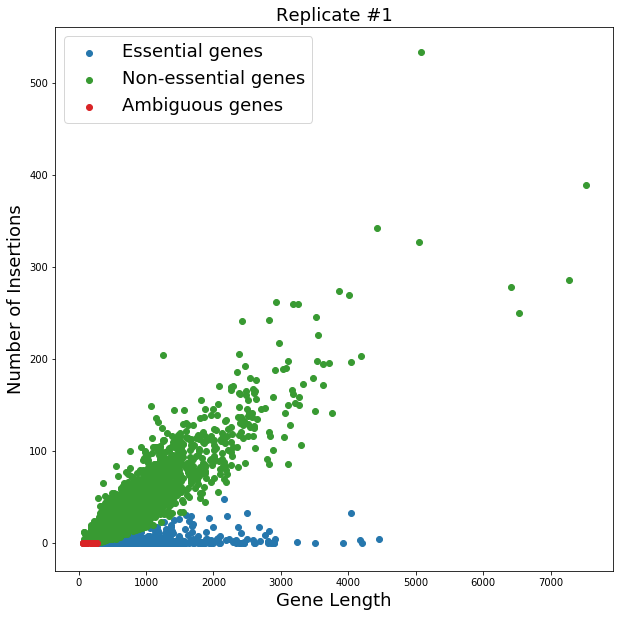

In [8]:
figure = plt.figure(figsize=(10,10))
pal = utils.qual_palette

mask_essential = merged_df.essentiality == 'essential'
mask_nonessential = merged_df.essentiality == 'nonessential'
mask_ambiguous = merged_df.essentiality == 'ambiguous'
plt.scatter(essential_df1[mask_essential].length,
            essential_df1[mask_essential].n_inserts,
            color=pal[1], label='Essential genes')
plt.scatter(essential_df1[mask_nonessential].length,
            essential_df1[mask_nonessential].n_inserts,
            color=pal[3], label='Non-essential genes')
plt.scatter(essential_df1[mask_ambiguous].length,
            essential_df1[mask_ambiguous].n_inserts,
            color=pal[5], label='Ambiguous genes')
plt.legend(loc=2, fontsize=18)

plt.title('Replicate #1', fontsize=18)
plt.xlabel('Gene Length', fontsize=18)
plt.ylabel('Number of Insertions', fontsize=18)
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


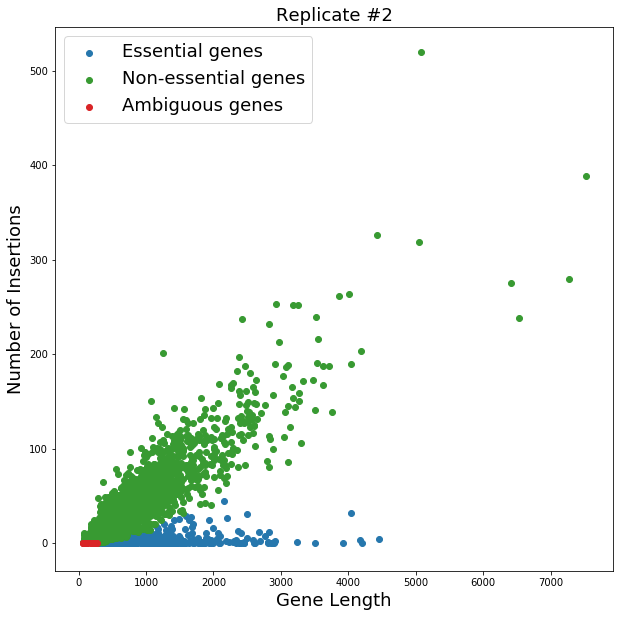

In [9]:
figure = plt.figure(figsize=(10,10))
pal = utils.qual_palette

mask_essential = merged_df.essentiality == 'essential'
mask_nonessential = merged_df.essentiality == 'nonessential'
mask_ambiguous = merged_df.essentiality == 'ambiguous'
plt.scatter(essential_df2[mask_essential].length,
            essential_df2[mask_essential].n_inserts,
            color=pal[1], label='Essential genes')
plt.scatter(essential_df2[mask_nonessential].length,
            essential_df2[mask_nonessential].n_inserts,
            color=pal[3], label='Non-essential genes')
plt.scatter(essential_df2[mask_ambiguous].length,
            essential_df2[mask_ambiguous].n_inserts,
            color=pal[5], label='Ambiguous genes')
plt.legend(loc=2, fontsize=18)

plt.title('Replicate #2', fontsize=18)
plt.xlabel('Gene Length', fontsize=18)
plt.ylabel('Number of Insertions', fontsize=18)
plt.show()